In [3]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt


# Importing raw ppg data into a dictionary

In [4]:
import os
import re
import numpy as np

def load_ppg_signals_from_folder(folder_path):
    """
    Load raw PPG signals from a folder where all .txt files are located.
    
    Parameters:
    - folder_path: Path to the folder containing all .txt files.
    
    Returns:
    - ppg_data: A dictionary where keys are subject IDs and values are lists of signal segments.
    """
    ppg_data = {}
    # Regular expression to extract subject ID and segment number
    file_pattern = re.compile(r"(\d+)_(\d+)\.txt")

    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            match = file_pattern.match(filename)
            if match:
                subject_id = int(match.group(1))
                segment_id = int(match.group(2))
                
                # Load the raw PPG signal from the file
                file_path = os.path.join(folder_path, filename)
                raw_signal = np.loadtxt(file_path)
                
                # Store in the dictionary
                if subject_id not in ppg_data:
                    ppg_data[subject_id] = []
                
                # Append the signal according to its segment number
                ppg_data[subject_id].append((segment_id, raw_signal))
    
    # Sort the segments by their segment number for each subject
    for subject_id in ppg_data:
        ppg_data[subject_id] = [signal for _, signal in sorted(ppg_data[subject_id])]
    
    return ppg_data

# Example usage
folder_path = '0_subject'
ppg_signals = load_ppg_signals_from_folder('./0_subject/')


In [95]:
ppg_data

NameError: name 'ppg_data' is not defined

In [6]:
sorted_ppg = dict(sorted(ppg_signals.items()))
sorted_ppg

{2: [array([2438., 2438., 2438., ..., 1827., 1754., 1754.]),
  array([2201., 2201., 2171., ..., 1997., 1997., 1997.]),
  array([2019., 2014., 2014., ..., 1924., 1929., 1929.])],
 3: [array([1973., 1973., 1990., ..., 2036., 2036., 2045.]),
  array([2008., 1982., 1982., ..., 2003., 2003., 1989.]),
  array([1965., 1965., 1960., ..., 2005., 2005., 2005.])],
 6: [array([2003., 2003., 1978., ..., 2038., 2038., 2038.]),
  array([1903., 1903., 1921., ..., 2067., 2067., 2067.]),
  array([1942., 1912., 1912., ..., 2168., 2168., 2175.])],
 8: [array([2039., 2039., 2039., ..., 1995., 1972., 1972.]),
  array([2097., 2101., 2101., ..., 2033., 2033., 2022.]),
  array([2051., 2058., 2058., ..., 2015., 2021., 2021.])],
 9: [array([1961., 1971., 1971., ..., 2046., 2046., 2031.]),
  array([2011., 2021., 2021., ..., 1973., 2019., 2019.]),
  array([1939., 1939., 1959., ..., 1971., 1971., 1966.])],
 10: [array([1967., 2008., 2008., ..., 2109., 2083., 2083.]),
  array([2078., 2078., 2078., ..., 2109., 2116.,

# denoising raw ppg using Discrete Wavelet transform (DWT) 

In [7]:
import numpy as np
import pywt



# Function to process PPG signals for each segment using 12-level DWT
def process_ppg_signals(ppg_data, wavelet='db8', level=5):
    processed_signals = {}
    for subject_id, signal_segments in ppg_data.items():
        processed_segments = []
        
        # Process each segment of the signal for the subject
        for segment in signal_segments:
            # Perform wavelet decomposition
            coeffs = pywt.wavedec(segment, wavelet, level=level)
            
            # Suppress high-frequency detail coefficients (set them to zero)
            for i in range(1, len(coeffs)):
                coeffs[i] = np.zeros_like(coeffs[i])
            
            # Reconstruct the signal using remaining coefficients
            reconstructed_segment = pywt.waverec(coeffs, wavelet)
            processed_segments.append(reconstructed_segment)
        
        # Add processed segments to the dictionary
        processed_signals[subject_id] = processed_segments
    
    return processed_signals

# Process the raw PPG signals
processed_ppg_signals = process_ppg_signals(sorted_ppg)

# Output: Dictionary with subject_id as key and list of processed arrays as values
for subject_id, processed_segments in processed_ppg_signals.items():
    print(f"Subject {subject_id}:")
    for i, segment in enumerate(processed_segments):
        print(f"  Segment {i + 1}: {segment[:10]}")


Subject 2:
  Segment 1: [2414.34114761 2412.98110729 2411.54794213 2410.04118591 2408.45827719
 2406.79378556 2405.04432376 2403.20882589 2401.28769792 2399.28526665]
  Segment 2: [2157.55954795 2156.7499672  2155.88949622 2154.97680704 2154.00980629
 2152.98546813 2151.90138237 2150.75567558 2149.54695414 2148.27513475]
  Segment 3: [2006.64164544 2006.24171277 2005.82719063 2005.39862801 2004.955957
 2004.49822668 2004.02517342 2003.53737959 2003.03592504 2002.52315179]
Subject 3:
  Segment 1: [1971.49181655 1971.1976117  1970.89744667 1970.59235835 1970.28254351
 1969.96694185 1969.64544616 1969.31918579 1968.98994778 1968.66122496]
  Segment 2: [1996.48366516 1996.44158506 1996.39365102 1996.33944028 1996.27856551
 1996.21073097 1996.13555188 1996.05247629 1995.96089918 1995.86009465]
  Segment 3: [1957.16480263 1957.11134041 1957.05584036 1956.99844342 1956.93901012
 1956.87696946 1956.8120486  1956.74437998 1956.67428681 1956.60262104]
Subject 6:
  Segment 1: [1989.19128612 1988.

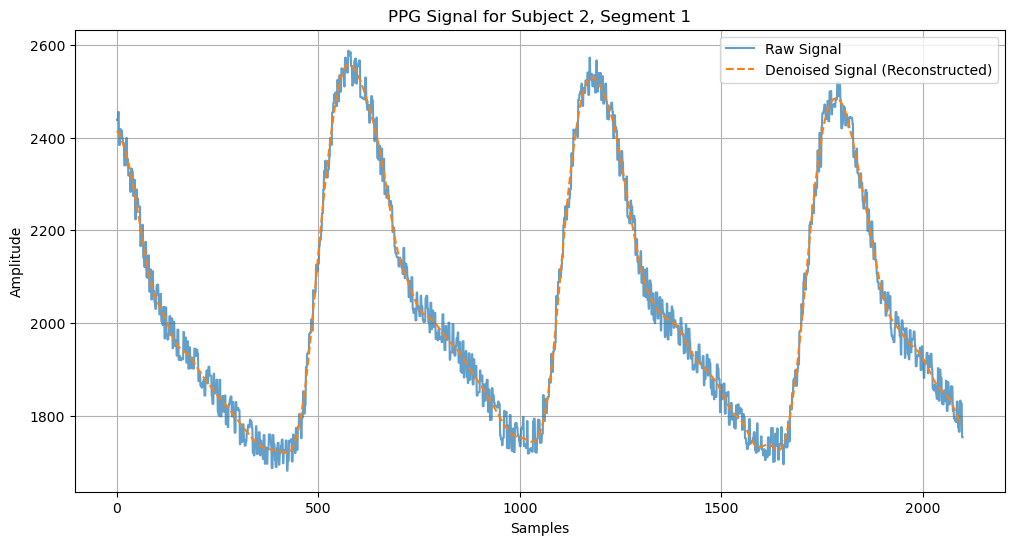

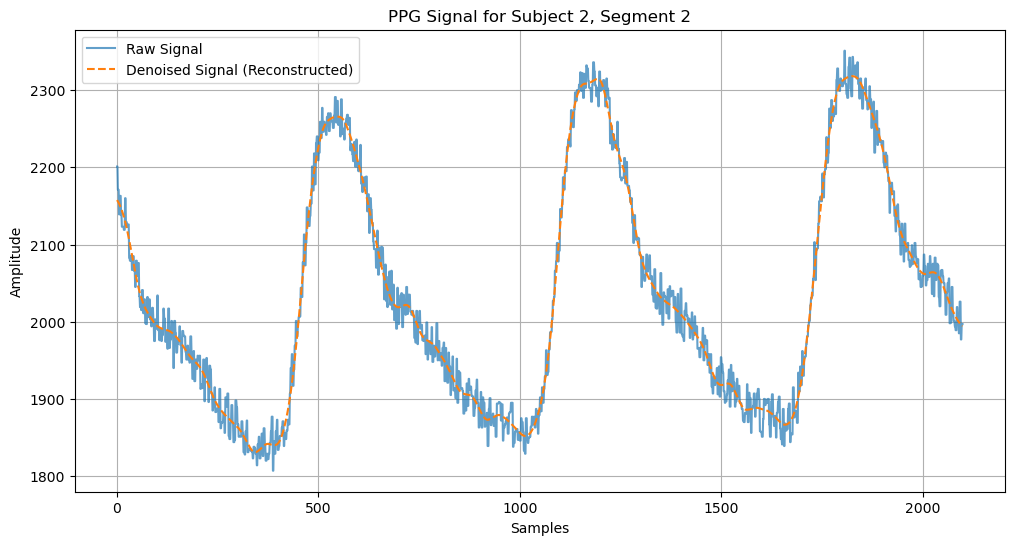

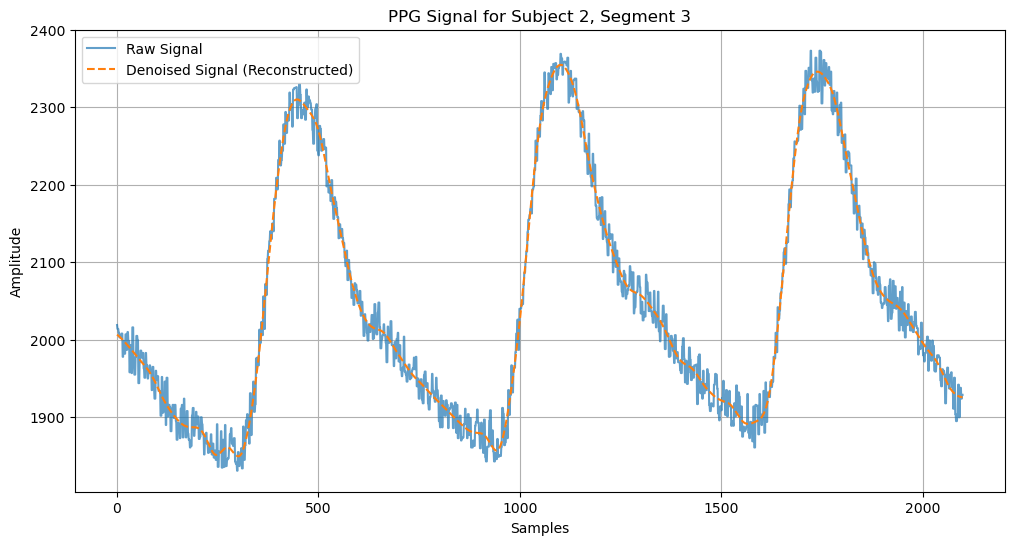

In [8]:
# Function to plot original and processed signals for a subject
def plot_ppg_signals(subject_id, raw_signals, processed_signals):
    if subject_id not in raw_signals or subject_id not in processed_signals:
        print(f"Subject ID {subject_id} not found.")
        return

    raw_segments = raw_signals[subject_id]
    processed_segments = processed_signals[subject_id]

    for i, (raw, processed) in enumerate(zip(raw_segments, processed_segments)):
        plt.figure(figsize=(12, 6))
        plt.plot(raw, label='Raw Signal', alpha=0.7)
        plt.plot(processed, label='Denoised Signal (Reconstructed)', linestyle='--')
        plt.title(f"PPG Signal for Subject {subject_id}, Segment {i + 1}")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid()
        plt.show()

# Plot PPG signals for subject 2
plot_ppg_signals(subject_id=2, raw_signals=sorted_ppg, processed_signals=processed_ppg_signals)

# smoothning denoised ppg using Savitzky Golay (SG) filter

In [9]:
import numpy as np
from scipy.signal import savgol_filter



# Function to smooth PPG signals using Savitzky-Golay filter
def smooth_ppg_signals(ppg_data, window_length=5, polyorder=2):
    smoothed_signals = {}
    for subject_id, signal_segments in ppg_data.items():
        smoothed_segments = []
        
        # Apply SG filter to each segment
        for segment in signal_segments:
            # Ensure window length is valid (odd and <= segment length)
            valid_window_length = min(len(segment), window_length)
            if valid_window_length % 2 == 0:
                valid_window_length += 1
            
            # Apply Savitzky-Golay filter
            smoothed_segment = savgol_filter(segment, window_length=valid_window_length, polyorder=polyorder)
            smoothed_segments.append(smoothed_segment)
        
        # Add smoothed segments to the dictionary
        smoothed_signals[subject_id] = smoothed_segments
    
    return smoothed_signals

# Apply Savitzky-Golay smoothing to the PPG signals
smoothed_ppg_signals = smooth_ppg_signals(processed_ppg_signals)

# Output: Dictionary with subject_id as key and list of smoothed arrays as values
for subject_id, smoothed_segments in smoothed_ppg_signals.items():
    print(f"Subject {subject_id}:")
    for i, segment in enumerate(smoothed_segments):
        print(f"  Segment {i + 1}: {segment[:10]}")


Subject 2:
  Segment 1: [2414.34087477 2412.98159309 2411.54812172 2410.04143182 2408.45810207
 2406.79358659 2405.0441976  2403.20848982 2401.2878101  2399.28571405]
  Segment 2: [2157.55921675 2156.75060773 2155.88956183 2154.97688697 2154.00975352
 2152.98542212 2151.90134124 2150.75556326 2149.54700135 2148.27528544]
  Segment 3: [2006.64170236 2006.2415813  2005.8272435  2005.39870369 2004.95589809
 2004.49815417 2004.02513078 2003.5372714  2003.0359547  2002.52329059]
Subject 3:
  Segment 1: [1971.49195191 1971.19731696 1970.89751868 1970.5924661  1970.28246181
 1969.96683586 1969.64538979 1969.31903958 1968.98998666 1968.66141711]
  Segment 2: [1996.48358364 1996.4417491  1996.39364798 1996.33943243 1996.27857314
 1996.2107453  1996.13555643 1996.05248665 1995.96089985 1995.86008178]
  Segment 3: [1957.16480678 1957.11132409 1957.05586439 1956.99848041 1956.93898456
 1956.87693472 1956.81203225 1956.74433466 1956.67430002 1956.60268451]
Subject 6:
  Segment 1: [1989.19148173 198

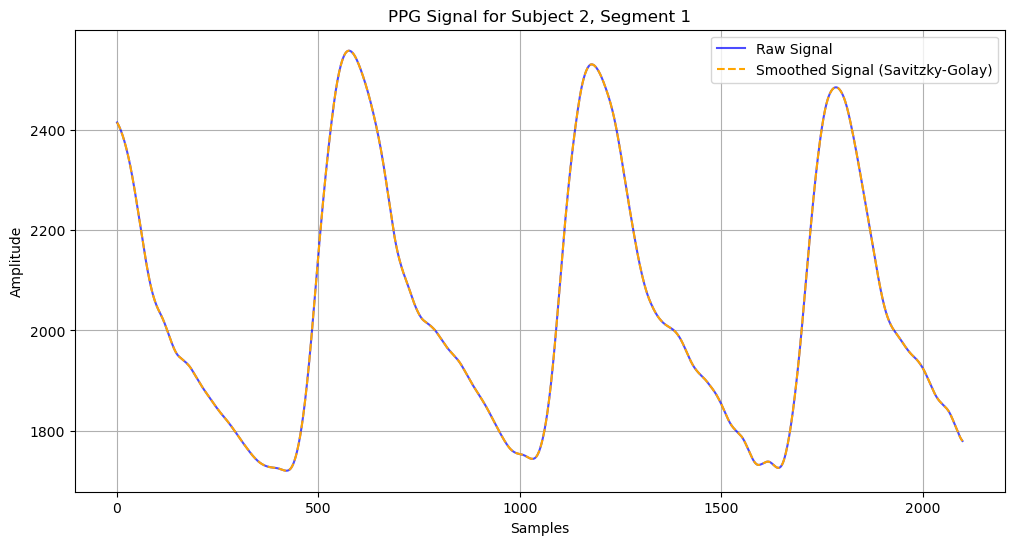

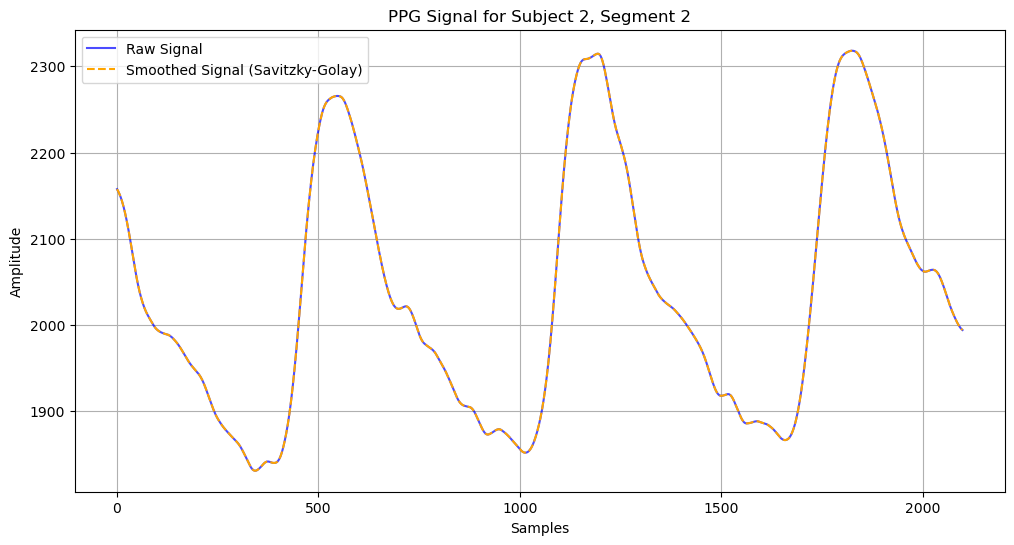

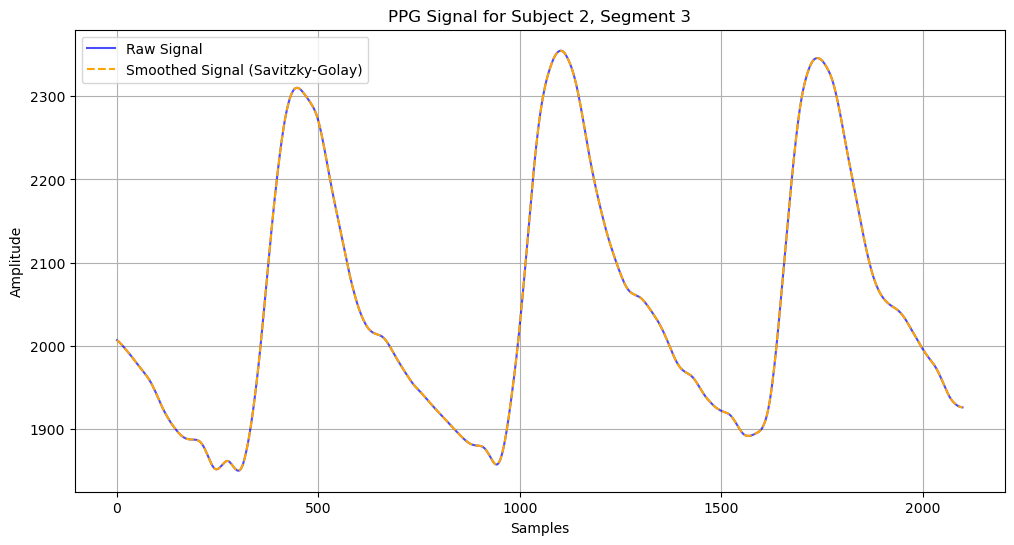

In [10]:
# Function to plot original and smoothed PPG signals
def plot_ppg_signals(subject_id, raw_signals, smoothed_signals):
    if subject_id not in raw_signals or subject_id not in smoothed_signals:
        print(f"Subject ID {subject_id} not found.")
        return

    raw_segments = raw_signals[subject_id]
    smoothed_segments = smoothed_signals[subject_id]

    for i, (raw, smoothed) in enumerate(zip(raw_segments, smoothed_segments)):
        plt.figure(figsize=(12, 6))
        plt.plot(raw, label='Raw Signal', alpha=0.7, color='blue')
        plt.plot(smoothed, label='Smoothed Signal (Savitzky-Golay)', linestyle='--', color='orange')
        plt.title(f"PPG Signal for Subject {subject_id}, Segment {i + 1}")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid()
        plt.show()

# Plot PPG signals for subject 2
plot_ppg_signals(subject_id=2, raw_signals=processed_ppg_signals, smoothed_signals=smoothed_ppg_signals)

# computing higher order derivatives

In [11]:
# Function to compute first, second, and third derivatives
def compute_higher_order_derivatives(ppg_data):
    derivatives = {}
    for subject_id, signal_segments in ppg_data.items():
        derivatives[subject_id] = []
        
        # Compute derivatives for each segment
        for segment in signal_segments:
            # First derivative (VPPG)
            first_derivative = np.gradient(segment)
            
            # Second derivative (APPG)
            second_derivative = np.gradient(first_derivative)
            
            # Third derivative (JPPG)
            third_derivative = np.gradient(second_derivative)
            
            # Store derivatives for this segment
            derivatives[subject_id].append({
                
                "APPG": second_derivative,
                "JPPG": third_derivative,
            })
    
    return derivatives

# Compute higher-order derivatives for the PPG signals
ppg_derivatives = compute_higher_order_derivatives(smoothed_ppg_signals)

# Output: Dictionary with subject_id as key and derivatives as values
for subject_id, segments in ppg_derivatives.items():
    print(f"Subject {subject_id}:")
    for i, derivative_set in enumerate(segments):
        print(f"  Segment {i + 1}:")
        
        print(f"    APPG  : {derivative_set['APPG'][:10]}")  # Second derivative
        print(f"    JPPG  : {derivative_set['JPPG'][:10]}")  # Third derivative

Subject 2:
  Segment 1:
    APPG  : [-0.03709485 -0.05539948 -0.07431665 -0.07692099 -0.0809712  -0.08431288
 -0.08562076 -0.08441975 -0.08175295 -0.07991908]
    JPPG  : [-1.83046309e-02 -1.86109017e-02 -1.07607564e-02 -3.32727539e-03
 -3.69594610e-03 -2.32477923e-03 -5.34343883e-05  1.93390486e-03
  2.25033606e-03  8.96329885e-04]
  Segment 2:
    APPG  : [-0.02621844 -0.03912568 -0.05253835 -0.05443602 -0.05715099 -0.0595985
 -0.0614819  -0.06260474 -0.06327919 -0.06427858]
    JPPG  : [-0.01290724 -0.01315995 -0.00765517 -0.00230632 -0.00258124 -0.00216545
 -0.00150312 -0.00089864 -0.00083692 -0.00135122]
  Segment 3:
    APPG  : [-0.00710837 -0.01065887 -0.01422164 -0.01441798 -0.01485547 -0.01508331
 -0.01460219 -0.01327451 -0.01144304 -0.00983267]
    JPPG  : [-0.0035505  -0.00355664 -0.00187955 -0.00031692 -0.00033267  0.00012664
  0.0009044   0.00157957  0.00172092  0.00134125]
Subject 3:
  Segment 1:
    APPG  : [-0.00258166 -0.00389524 -0.00515591 -0.00519484 -0.00550379 -0.

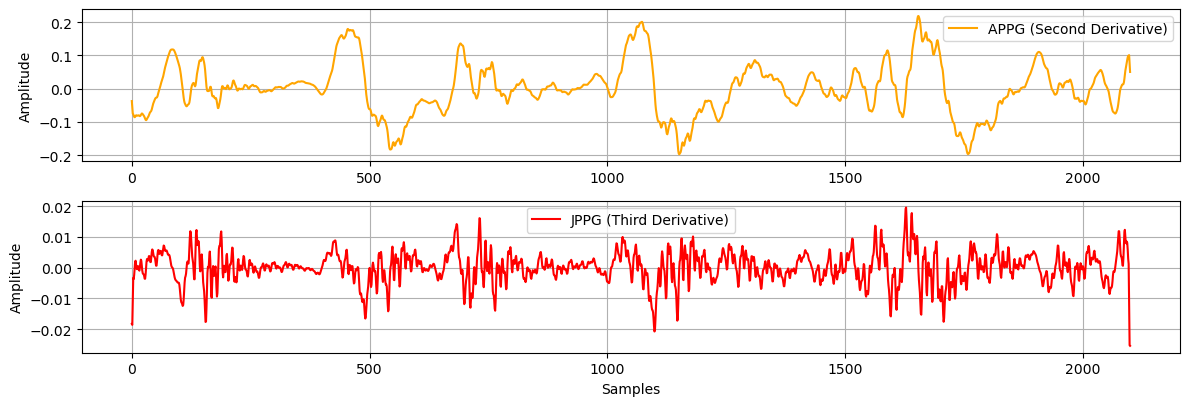

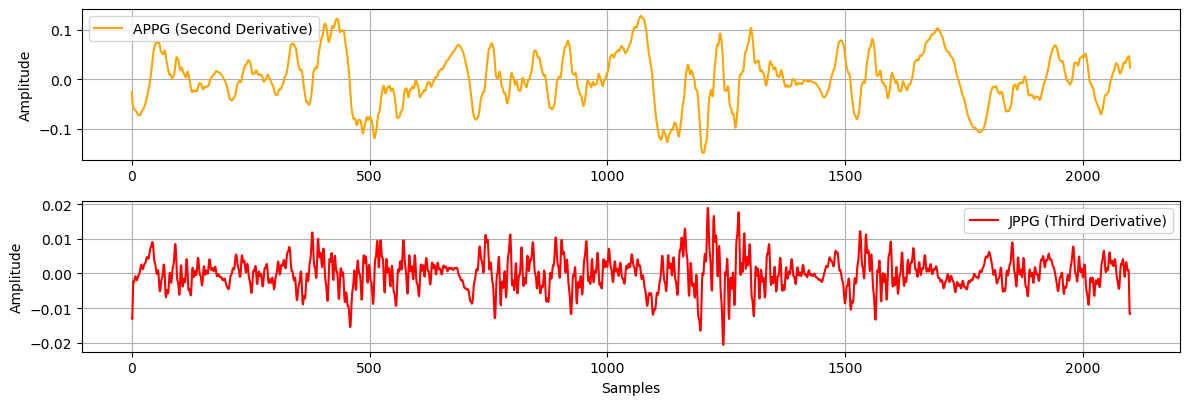

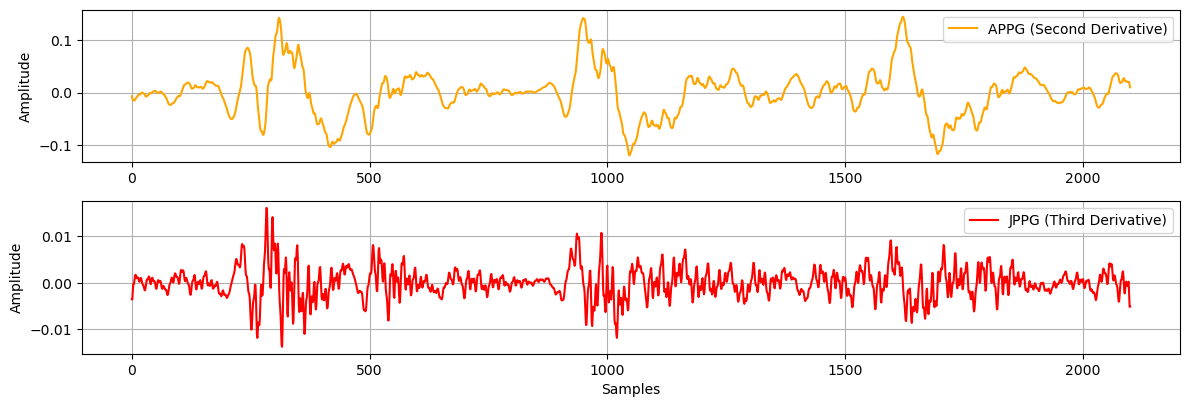

In [12]:
# Function to plot derivatives
def plot_derivatives(subject_id, derivatives):
    if subject_id not in derivatives:
        print(f"Subject ID {subject_id} not found.")
        return

    for i, derivative_set in enumerate(derivatives[subject_id]):
        plt.figure(figsize=(12, 8))
        
        
        
        # Plot APPG (Second Derivative)
        plt.subplot(4, 1, 3)
        plt.plot(derivative_set["APPG"], label='APPG (Second Derivative)', color='orange')
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid()
        
        # Plot JPPG (Third Derivative)
        plt.subplot(4, 1, 4)
        plt.plot(derivative_set["JPPG"], label='JPPG (Third Derivative)', color='red')
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()

# Plot derivatives for subject 2
plot_derivatives(subject_id=2, derivatives=ppg_derivatives)

# computing spectral entropy

In [13]:
import numpy as np
from scipy.signal import welch

# Function to compute the power spectral density (PSD) using Welch's method
def compute_power_spectrum(signal, fs):
    freqs, psd = welch(signal, fs=fs)
    return psd

# Function to compute spectral entropy from the PSD
def compute_entropy(psd):
    psd_normalized = psd / np.sum(psd)  # Normalize PSD to get probabilities
    entropy = -np.sum(psd_normalized * np.log2(psd_normalized + 1e-12))  # Avoid log(0) with small epsilon
    return entropy

# Function to calculate spectral entropy for each segment in the dictionary
def calculate_spectral_entropy_for_segments(signals_dict, fs):
    spectral_entropy_results = {}
    for subject_id, segments in signals_dict.items():
        spectral_entropy_results[subject_id] = []
        
        # Iterate over each segment
        for segment in segments:
            segment_entropy = {}
            
            # Calculate spectral entropy for APPG
            psd_appg = compute_power_spectrum(segment["APPG"], fs)
            segment_entropy["APPG_SpectralEntropy"] = compute_entropy(psd_appg)
            
            # Calculate spectral entropy for JPPG
            psd_jppg = compute_power_spectrum(segment["JPPG"], fs)
            segment_entropy["JPPG_SpectralEntropy"] = compute_entropy(psd_jppg)
            
            spectral_entropy_results[subject_id].append(segment_entropy)
    
    return spectral_entropy_results


# Sampling frequency (in Hz)
fs = 100

# Calculate spectral entropy for all signals
spectral_entropy_results = calculate_spectral_entropy_for_segments(ppg_derivatives, fs)

# Print results
for subject_id, segments in spectral_entropy_results.items():
    print(f"Subject {subject_id}:")
    for i, segment_entropy in enumerate(segments):
        print(f"  Segment {i + 1}:")
        print(f"    APPG Spectral Entropy: {segment_entropy['APPG_SpectralEntropy']:.4f}")
        print(f"    JPPG Spectral Entropy: {segment_entropy['JPPG_SpectralEntropy']:.4f}")


Subject 2:
  Segment 1:
    APPG Spectral Entropy: 2.3135
    JPPG Spectral Entropy: 4.0426
  Segment 2:
    APPG Spectral Entropy: 2.7678
    JPPG Spectral Entropy: 3.9127
  Segment 3:
    APPG Spectral Entropy: 2.2163
    JPPG Spectral Entropy: 3.9507
Subject 3:
  Segment 1:
    APPG Spectral Entropy: 2.7189
    JPPG Spectral Entropy: 3.6930
  Segment 2:
    APPG Spectral Entropy: 2.7722
    JPPG Spectral Entropy: 3.7750
  Segment 3:
    APPG Spectral Entropy: 2.7532
    JPPG Spectral Entropy: 3.8350
Subject 6:
  Segment 1:
    APPG Spectral Entropy: 2.7155
    JPPG Spectral Entropy: 3.8164
  Segment 2:
    APPG Spectral Entropy: 2.7852
    JPPG Spectral Entropy: 3.7888
  Segment 3:
    APPG Spectral Entropy: 2.8542
    JPPG Spectral Entropy: 3.7787
Subject 8:
  Segment 1:
    APPG Spectral Entropy: 2.6551
    JPPG Spectral Entropy: 3.8007
  Segment 2:
    APPG Spectral Entropy: 2.8460
    JPPG Spectral Entropy: 3.8454
  Segment 3:
    APPG Spectral Entropy: 2.6925
    JPPG Spectral 

## spectral entropy dataframe

In [14]:
import pandas as pd

spectral_rows = []
for subject, segments in spectral_entropy_results.items():
    for idx, segment in enumerate(segments, start=1):
        row = {'Subject': subject, 'Segment': f'Segment {idx}'}
        row.update(segment)
        spectral_rows.append(row)

spectral_df = pd.DataFrame(spectral_rows)

# Display DataFrame
print(spectral_df)

     Subject    Segment  APPG_SpectralEntropy  JPPG_SpectralEntropy
0          2  Segment 1              2.313500              4.042557
1          2  Segment 2              2.767754              3.912706
2          2  Segment 3              2.216267              3.950677
3          3  Segment 1              2.718942              3.693033
4          3  Segment 2              2.772210              3.775030
..       ...        ...                   ...                   ...
652      418  Segment 2              2.178182              3.973968
653      418  Segment 3              2.233224              4.019234
654      419  Segment 1              2.306700              4.083273
655      419  Segment 2              2.053017              4.030790
656      419  Segment 3              2.337938              4.105255

[657 rows x 4 columns]


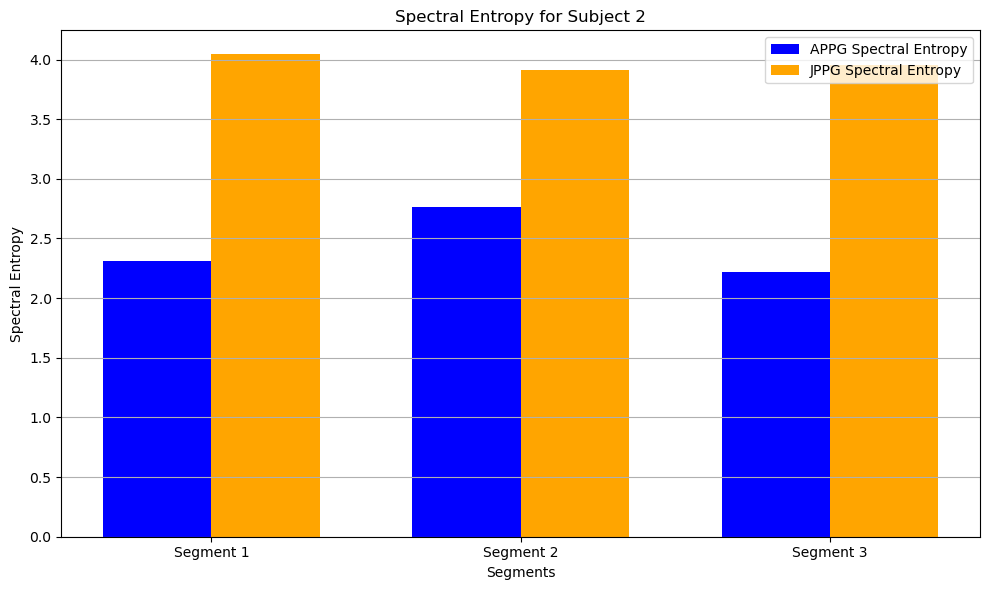

In [15]:
# Function to plot spectral entropy for a single subject
def plot_spectral_entropy_for_subject(subject_id, entropy_results):
    if subject_id not in entropy_results:
        print(f"Subject ID {subject_id} not found.")
        return

    appg_entropies = [segment["APPG_SpectralEntropy"] for segment in entropy_results[subject_id]]
    jppg_entropies = [segment["JPPG_SpectralEntropy"] for segment in entropy_results[subject_id]]

    # Bar graph
    x = np.arange(len(entropy_results[subject_id]))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width / 2, appg_entropies, width, label='APPG Spectral Entropy', color='blue')
    plt.bar(x + width / 2, jppg_entropies, width, label='JPPG Spectral Entropy', color='orange')
    
    plt.title(f"Spectral Entropy for Subject {subject_id}")
    plt.xlabel("Segments")
    plt.ylabel("Spectral Entropy")
    plt.xticks(x, [f"Segment {i+1}" for i in x])
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Plot spectral entropy for Subject 2
plot_spectral_entropy_for_subject(subject_id=2, entropy_results=spectral_entropy_results)

# computing attention entropy

In [16]:
import numpy as np

# Function to compute attention weights
def compute_attention_weights(signal):
    """
    Compute attention weights as a function of similarity between a signal value 
    and its neighbors using a Gaussian kernel.
    """
    n = len(signal)
    weights = np.zeros(n)
    for i in range(n):
        # Define a similarity function (Gaussian kernel for neighbors)
        neighbors = np.array(signal[max(0, i - 2):min(n, i + 3)])  # 5-point window
        weights[i] = np.exp(-np.sum((signal[i] - neighbors) ** 2))
    
    # Normalize the weights
    weights /= np.sum(weights)
    return weights

# Function to compute attention entropy
def compute_attention_entropy(signal):
    """
    Compute attention entropy using normalized attention weights.
    """
    attention_weights = compute_attention_weights(signal)
    entropy = -np.sum(attention_weights * np.log2(attention_weights + 1e-12))  # Avoid log(0)
    return entropy

# Function to calculate attention entropy for all segments in the dictionary
def calculate_attention_entropy_for_segments(signals_dict):
    attention_entropy_results = {}
    for subject_id, segments in signals_dict.items():
        attention_entropy_results[subject_id] = []
        
        # Iterate over each segment
        for segment in segments:
            segment_entropy = {}
            
            # Calculate attention entropy for APPG
            segment_entropy["APPG_AttentionEntropy"] = compute_attention_entropy(segment["APPG"])
            
            # Calculate attention entropy for JPPG
            segment_entropy["JPPG_AttentionEntropy"] = compute_attention_entropy(segment["JPPG"])
            
            attention_entropy_results[subject_id].append(segment_entropy)
    
    return attention_entropy_results



# Calculate attention entropy for all signals
attention_entropy_results = calculate_attention_entropy_for_segments(ppg_derivatives)

# Print results
for subject_id, segments in attention_entropy_results.items():
    print(f"Subject {subject_id}:")
    for i, segment_entropy in enumerate(segments):
        print(f"  Segment {i + 1}:")
        print(f"    APPG Attention Entropy: {segment_entropy['APPG_AttentionEntropy']:.4f}")
        print(f"    JPPG Attention Entropy: {segment_entropy['JPPG_AttentionEntropy']:.4f}")


Subject 2:
  Segment 1:
    APPG Attention Entropy: 11.0362
    JPPG Attention Entropy: 11.0362
  Segment 2:
    APPG Attention Entropy: 11.0362
    JPPG Attention Entropy: 11.0362
  Segment 3:
    APPG Attention Entropy: 11.0362
    JPPG Attention Entropy: 11.0362
Subject 3:
  Segment 1:
    APPG Attention Entropy: 11.0362
    JPPG Attention Entropy: 11.0362
  Segment 2:
    APPG Attention Entropy: 11.0362
    JPPG Attention Entropy: 11.0362
  Segment 3:
    APPG Attention Entropy: 11.0362
    JPPG Attention Entropy: 11.0362
Subject 6:
  Segment 1:
    APPG Attention Entropy: 11.0362
    JPPG Attention Entropy: 11.0362
  Segment 2:
    APPG Attention Entropy: 11.0362
    JPPG Attention Entropy: 11.0362
  Segment 3:
    APPG Attention Entropy: 11.0362
    JPPG Attention Entropy: 11.0362
Subject 8:
  Segment 1:
    APPG Attention Entropy: 11.0362
    JPPG Attention Entropy: 11.0362
  Segment 2:
    APPG Attention Entropy: 11.0362
    JPPG Attention Entropy: 11.0362
  Segment 3:
    APPG

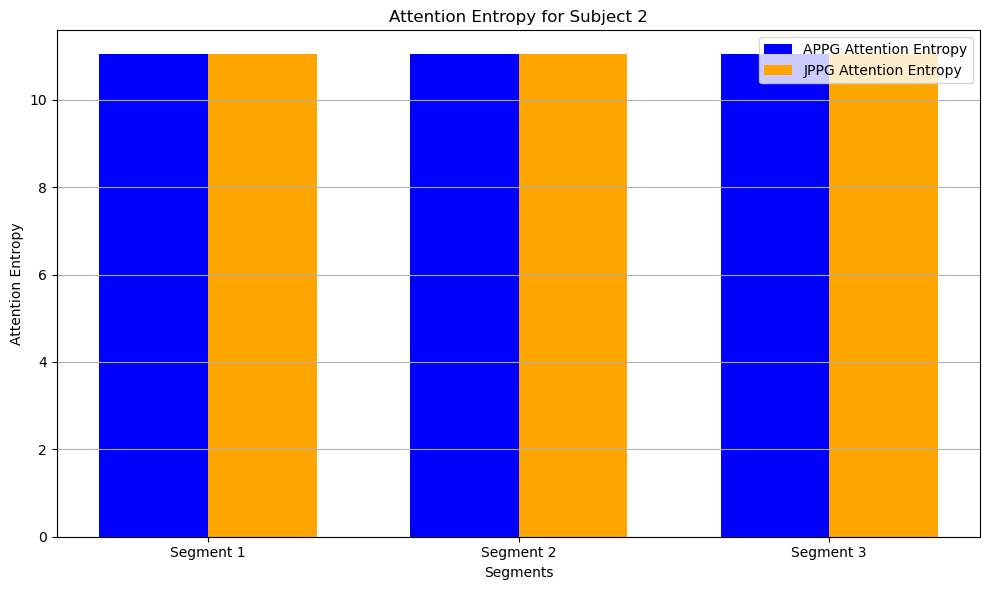

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot attention entropy for a single subject
def plot_attention_entropy_for_subject(subject_id, attention_entropy_results):
    if subject_id not in attention_entropy_results:
        print(f"Subject ID {subject_id} not found.")
        return

    appg_entropies = [segment["APPG_AttentionEntropy"] for segment in attention_entropy_results[subject_id]]
    jppg_entropies = [segment["JPPG_AttentionEntropy"] for segment in attention_entropy_results[subject_id]]

    # Bar graph
    x = np.arange(len(attention_entropy_results[subject_id]))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width / 2, appg_entropies, width, label='APPG Attention Entropy', color='blue')
    plt.bar(x + width / 2, jppg_entropies, width, label='JPPG Attention Entropy', color='orange')
    
    plt.title(f"Attention Entropy for Subject {subject_id}")
    plt.xlabel("Segments")
    plt.ylabel("Attention Entropy")
    plt.xticks(x, [f"Segment {i+1}" for i in x])
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Example: Plot attention entropy for Subject 2
plot_attention_entropy_for_subject(subject_id=2, attention_entropy_results=attention_entropy_results)


## attention entropy dataframe

In [18]:
import pandas as pd

attention_rows = []
for subject, segments in attention_entropy_results.items():
    for idx, segment in enumerate(segments, start=1):
        row = {'Subject': subject, 'Segment': f'Segment {idx}'}
        row.update(segment)
        attention_rows.append(row)

attention_df = pd.DataFrame(attention_rows)

# Display DataFrame
print(attention_df)

     Subject    Segment  APPG_AttentionEntropy  JPPG_AttentionEntropy
0          2  Segment 1              11.036173              11.036174
1          2  Segment 2              11.036174              11.036174
2          2  Segment 3              11.036174              11.036174
3          3  Segment 1              11.036174              11.036174
4          3  Segment 2              11.036174              11.036174
..       ...        ...                    ...                    ...
652      418  Segment 2              11.036173              11.036174
653      418  Segment 3              11.036173              11.036174
654      419  Segment 1              11.036173              11.036174
655      419  Segment 2              11.036172              11.036173
656      419  Segment 3              11.036172              11.036174

[657 rows x 4 columns]


# computing dispersion entropy

In [19]:
import numpy as np

# Function to compute dispersion patterns
def compute_dispersion_patterns(signal, embedding_dim, time_delay, num_classes):
    """
    Compute dispersion patterns for a given signal based on embedding dimension, time delay, and classes.
    """
    n = len(signal)
    patterns = []

    # Scale the signal to [0, 1] and quantize into num_classes
    normalized_signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal) + 1e-12)
    quantized_signal = np.floor(normalized_signal * num_classes).astype(int)

    # Generate dispersion patterns
    for i in range(n - (embedding_dim - 1) * time_delay):
        pattern = tuple(quantized_signal[i + j * time_delay] for j in range(embedding_dim))
        patterns.append(pattern)
    
    return patterns

# Function to compute dispersion entropy
def compute_dispersion_entropy(signal, embedding_dim, time_delay, num_classes):
    """
    Compute dispersion entropy for a given signal.
    """
    patterns = compute_dispersion_patterns(signal, embedding_dim, time_delay, num_classes)
    unique_patterns, counts = np.unique(patterns, axis=0, return_counts=True)
    probabilities = counts / np.sum(counts)
    entropy = -np.sum(probabilities * np.log(probabilities + 1e-12))  # Avoid log(0)
    return entropy

# Function to calculate dispersion entropy for all segments in the dictionary
def calculate_dispersion_entropy_for_segments(signals_dict, embedding_dim=3, time_delay=1, num_classes=5):
    dispersion_entropy_results = {}
    for subject_id, segments in signals_dict.items():
        dispersion_entropy_results[subject_id] = []
        
        # Iterate over each segment
        for segment in segments:
            segment_entropy = {}
            
            # Calculate dispersion entropy for APPG
            segment_entropy["APPG_DispersionEntropy"] = compute_dispersion_entropy(
                segment["APPG"], embedding_dim, time_delay, num_classes
            )
            
            # Calculate dispersion entropy for JPPG
            segment_entropy["JPPG_DispersionEntropy"] = compute_dispersion_entropy(
                segment["JPPG"], embedding_dim, time_delay, num_classes
            )
            
            dispersion_entropy_results[subject_id].append(segment_entropy)
    
    return dispersion_entropy_results



# Calculate dispersion entropy for all signals
dispersion_entropy_results = calculate_dispersion_entropy_for_segments(ppg_derivatives)

# Print results
for subject_id, segments in dispersion_entropy_results.items():
    print(f"Subject {subject_id}:")
    for i, segment_entropy in enumerate(segments):
        print(f"  Segment {i + 1}:")
        print(f"    APPG Dispersion Entropy: {segment_entropy['APPG_DispersionEntropy']:.4f}")
        print(f"    JPPG Dispersion Entropy: {segment_entropy['JPPG_DispersionEntropy']:.4f}")


Subject 2:
  Segment 1:
    APPG Dispersion Entropy: 1.6664
    JPPG Dispersion Entropy: 1.8595
  Segment 2:
    APPG Dispersion Entropy: 1.8230
    JPPG Dispersion Entropy: 1.9042
  Segment 3:
    APPG Dispersion Entropy: 1.5093
    JPPG Dispersion Entropy: 1.6840
Subject 3:
  Segment 1:
    APPG Dispersion Entropy: 1.6030
    JPPG Dispersion Entropy: 1.8106
  Segment 2:
    APPG Dispersion Entropy: 1.5132
    JPPG Dispersion Entropy: 1.5626
  Segment 3:
    APPG Dispersion Entropy: 1.6718
    JPPG Dispersion Entropy: 2.0578
Subject 6:
  Segment 1:
    APPG Dispersion Entropy: 1.6905
    JPPG Dispersion Entropy: 1.9587
  Segment 2:
    APPG Dispersion Entropy: 1.4295
    JPPG Dispersion Entropy: 1.7916
  Segment 3:
    APPG Dispersion Entropy: 1.5029
    JPPG Dispersion Entropy: 1.6640
Subject 8:
  Segment 1:
    APPG Dispersion Entropy: 1.6032
    JPPG Dispersion Entropy: 1.5931
  Segment 2:
    APPG Dispersion Entropy: 1.4741
    JPPG Dispersion Entropy: 2.1230
  Segment 3:
    APPG

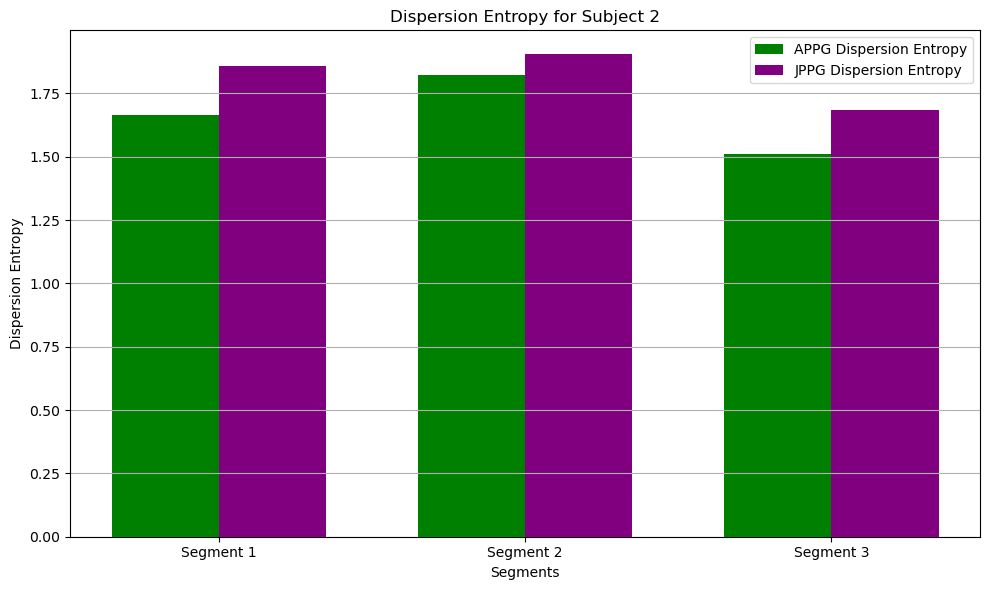

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot dispersion entropy for a single subject
def plot_dispersion_entropy_for_subject(subject_id, dispersion_entropy_results):
    if subject_id not in dispersion_entropy_results:
        print(f"Subject ID {subject_id} not found.")
        return

    appg_entropies = [segment["APPG_DispersionEntropy"] for segment in dispersion_entropy_results[subject_id]]
    jppg_entropies = [segment["JPPG_DispersionEntropy"] for segment in dispersion_entropy_results[subject_id]]

    # Bar graph
    x = np.arange(len(dispersion_entropy_results[subject_id]))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width / 2, appg_entropies, width, label='APPG Dispersion Entropy', color='green')
    plt.bar(x + width / 2, jppg_entropies, width, label='JPPG Dispersion Entropy', color='purple')
    
    plt.title(f"Dispersion Entropy for Subject {subject_id}")
    plt.xlabel("Segments")
    plt.ylabel("Dispersion Entropy")
    plt.xticks(x, [f"Segment {i+1}" for i in x])
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Example: Plot dispersion entropy for Subject 2
plot_dispersion_entropy_for_subject(subject_id=2, dispersion_entropy_results=dispersion_entropy_results)


## dispersion entropy dataframe

In [21]:
import pandas as pd

dispersion_rows = []
for subject, segments in dispersion_entropy_results.items():
    for idx, segment in enumerate(segments, start=1):
        row = {'Subject': subject, 'Segment': f'Segment {idx}'}
        row.update(segment)
        dispersion_rows.append(row)

dispersion_df = pd.DataFrame(dispersion_rows)

# Display DataFrame
print(dispersion_df)

     Subject    Segment  APPG_DispersionEntropy  JPPG_DispersionEntropy
0          2  Segment 1                1.666390                1.859452
1          2  Segment 2                1.823042                1.904156
2          2  Segment 3                1.509313                1.684023
3          3  Segment 1                1.603030                1.810594
4          3  Segment 2                1.513191                1.562650
..       ...        ...                     ...                     ...
652      418  Segment 2                1.118734                1.947940
653      418  Segment 3                0.893092                1.831222
654      419  Segment 1                1.123525                1.312766
655      419  Segment 2                0.953849                1.156685
656      419  Segment 3                1.076880                1.394760

[657 rows x 4 columns]


# computing slope entropy

In [22]:
import numpy as np

# Function to compute slope entropy for a single segment
def compute_slope_entropy(signal, segment_length, threshold):
    """
    Compute Slope Entropy (SlEn) for a given signal.
    """
    num_segments = len(signal) // segment_length
    entropy_sum = 0

    for i in range(num_segments):
        # Extract segment
        segment = signal[i * segment_length: (i + 1) * segment_length]

        # Compute slope values
        slope_values = np.diff(segment)

        # Count pairs based on threshold
        pair_count = np.sum(np.abs(slope_values) > threshold)

        # Calculate probability
        probability = pair_count / segment_length

        # Compute entropy for the segment
        if probability > 0:
            segment_entropy = -probability * np.log2(probability)
        else:
            segment_entropy = 0

        entropy_sum += segment_entropy

    # Average entropy across all segments
    slope_entropy = entropy_sum / num_segments if num_segments > 0 else 0
    return slope_entropy

# Function to calculate slope entropy for all segments in the dictionary
def calculate_slope_entropy_for_segments(signals_dict, segment_length=10, threshold=0.01):
    slope_entropy_results = {}
    for subject_id, segments in signals_dict.items():
        slope_entropy_results[subject_id] = []
        
        # Iterate over each segment
        for segment in segments:
            segment_entropy = {}
            
            # Calculate slope entropy for APPG
            segment_entropy["APPG_SlopeEntropy"] = compute_slope_entropy(
                segment["APPG"], segment_length, threshold
            )
            
            # Calculate slope entropy for JPPG
            segment_entropy["JPPG_SlopeEntropy"] = compute_slope_entropy(
                segment["JPPG"], segment_length, threshold
            )
            
            slope_entropy_results[subject_id].append(segment_entropy)
    
    return slope_entropy_results



# Calculate slope entropy for all signals
slope_entropy_results = calculate_slope_entropy_for_segments(ppg_derivatives)

# Print results
print(slope_entropy_results)

{2: [{'APPG_SlopeEntropy': 0.0907519061432528, 'JPPG_SlopeEntropy': 0.0022113600903689162}, {'APPG_SlopeEntropy': 0.06358575349530737, 'JPPG_SlopeEntropy': 0.0}, {'APPG_SlopeEntropy': 0.020305273578033745, 'JPPG_SlopeEntropy': 0.0}], 3: [{'APPG_SlopeEntropy': 0.008755989452218726, 'JPPG_SlopeEntropy': 0.0}, {'APPG_SlopeEntropy': 0.0015818705213749345, 'JPPG_SlopeEntropy': 0.0}, {'APPG_SlopeEntropy': 0.0, 'JPPG_SlopeEntropy': 0.0}], 6: [{'APPG_SlopeEntropy': 0.0015818705213749345, 'JPPG_SlopeEntropy': 0.0}, {'APPG_SlopeEntropy': 0.010390732027112111, 'JPPG_SlopeEntropy': 0.0}, {'APPG_SlopeEntropy': 0.038176722721596654, 'JPPG_SlopeEntropy': 0.0}], 8: [{'APPG_SlopeEntropy': 0.0, 'JPPG_SlopeEntropy': 0.0}, {'APPG_SlopeEntropy': 0.0, 'JPPG_SlopeEntropy': 0.0}, {'APPG_SlopeEntropy': 0.0, 'JPPG_SlopeEntropy': 0.0}], 9: [{'APPG_SlopeEntropy': 0.025474203564830572, 'JPPG_SlopeEntropy': 0.0}, {'APPG_SlopeEntropy': 0.023209971420943207, 'JPPG_SlopeEntropy': 0.0}, {'APPG_SlopeEntropy': 0.02482842

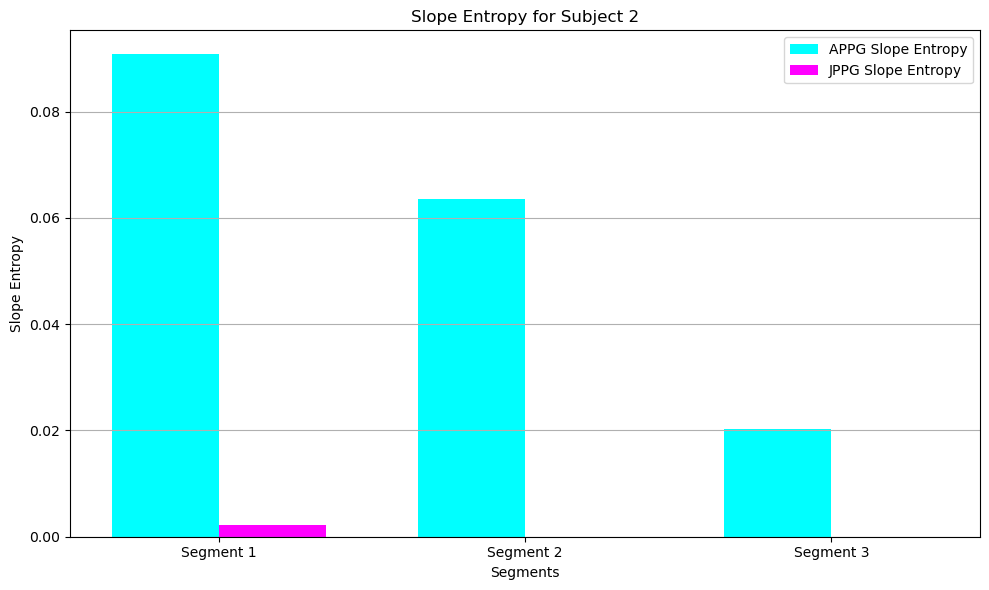

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot slope entropy for a single subject
def plot_slope_entropy_for_subject(subject_id, slope_entropy_results):
    if subject_id not in slope_entropy_results:
        print(f"Subject ID {subject_id} not found.")
        return

    appg_entropies = [segment["APPG_SlopeEntropy"] for segment in slope_entropy_results[subject_id]]
    jppg_entropies = [segment["JPPG_SlopeEntropy"] for segment in slope_entropy_results[subject_id]]

    # Bar graph
    x = np.arange(len(slope_entropy_results[subject_id]))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width / 2, appg_entropies, width, label='APPG Slope Entropy', color='cyan')
    plt.bar(x + width / 2, jppg_entropies, width, label='JPPG Slope Entropy', color='magenta')
    
    plt.title(f"Slope Entropy for Subject {subject_id}")
    plt.xlabel("Segments")
    plt.ylabel("Slope Entropy")
    plt.xticks(x, [f"Segment {i+1}" for i in x])
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Example: Plot slope entropy for Subject 2
plot_slope_entropy_for_subject(subject_id=2, slope_entropy_results=slope_entropy_results)


## slope entropy dataframe

In [24]:
import pandas as pd

slope_rows = []
for subject, segments in slope_entropy_results.items():
    for idx, segment in enumerate(segments, start=1):
        row = {'Subject': subject, 'Segment': f'Segment {idx}'}
        row.update(segment)
        slope_rows.append(row)

slope_df = pd.DataFrame(slope_rows)

# Display DataFrame
print(slope_df)


     Subject    Segment  APPG_SlopeEntropy  JPPG_SlopeEntropy
0          2  Segment 1           0.090752           0.002211
1          2  Segment 2           0.063586           0.000000
2          2  Segment 3           0.020305           0.000000
3          3  Segment 1           0.008756           0.000000
4          3  Segment 2           0.001582           0.000000
..       ...        ...                ...                ...
652      418  Segment 2           0.101555           0.002211
653      418  Segment 3           0.062260           0.006327
654      419  Segment 1           0.089366           0.001582
655      419  Segment 2           0.102716           0.003793
656      419  Segment 3           0.123542           0.022044

[657 rows x 4 columns]


## merging dataframes of 4 entropies

In [25]:
# Merge the DataFrames
merged_df = spectral_df.merge(attention_df, on=['Subject', 'Segment']).merge(dispersion_df, on=['Subject', 'Segment']).merge(slope_df, on=['Subject', 'Segment'])

# Display the merged DataFrame
print(merged_df)



     Subject    Segment  APPG_SpectralEntropy  JPPG_SpectralEntropy  \
0          2  Segment 1              2.313500              4.042557   
1          2  Segment 2              2.767754              3.912706   
2          2  Segment 3              2.216267              3.950677   
3          3  Segment 1              2.718942              3.693033   
4          3  Segment 2              2.772210              3.775030   
..       ...        ...                   ...                   ...   
652      418  Segment 2              2.178182              3.973968   
653      418  Segment 3              2.233224              4.019234   
654      419  Segment 1              2.306700              4.083273   
655      419  Segment 2              2.053017              4.030790   
656      419  Segment 3              2.337938              4.105255   

     APPG_AttentionEntropy  JPPG_AttentionEntropy  APPG_DispersionEntropy  \
0                11.036173              11.036174                1.666

In [26]:
file_path = "./merged_entropy_data.csv"
merged_df.to_csv(file_path, index=False)

# converting merged dataframe to 3_d matrix

In [27]:
import numpy as np

# Ensure there are 3 segments per subject
assert merged_df['Segment'].nunique() == 3, "Each subject must have exactly 3 segments."

# Sort the DataFrame by Subject and Segment to ensure proper alignment
df = merged_df.sort_values(by=['Subject', 'Segment'])

# Select columns for the 3D array, excluding 'Subject' and 'Segment'
feature_columns = df.columns.difference(['Subject', 'Segment'])

# Reshape data into 3D: (subjects, features, segments)
subjects = df['Subject'].nunique()
segments = 3  # As confirmed by the structure of the dataset
features = len(feature_columns)

# Convert to 3D array
data_3d = df[feature_columns].values.reshape(subjects, segments, features)

# Transpose to match (subjects, features, segments) shape
data_3d = np.transpose(data_3d, (0, 2, 1))

# Verify shape
print("3D Data Shape:", data_3d.shape)  # Should be (219, 8, 3)


3D Data Shape: (219, 8, 3)


In [28]:
# Extract axis labels
subject_labels = df['Subject'].unique()  # Unique subjects
feature_labels = feature_columns.tolist()  # Column names for features
segment_labels = df['Segment'].unique()  # Unique segments

# Display axis labels
print("Subject Labels (Axis 0):", subject_labels)
print("Feature Labels (Axis 1):", feature_labels)
print("Segment Labels (Axis 2):", segment_labels)

# Confirm shape
print("3D Data Shape:", data_3d.shape)  # Should match (subjects, features, segments)


Subject Labels (Axis 0): [  2   3   6   8   9  10  11  12  13  14  15  16  17  18  19  21  22  23
  24  25  26  27  29  30  31  32  34  35  38  40  41  43  45  47  48  50
  51  52  53  54  55  56  57  58  60  61  62  63  64  65  66  67  83  84
  85  86  87  88  89  90  91  92  93  95  96  97  98  99 100 103 104 105
 106 107 108 110 111 112 113 114 115 116 119 120 122 123 124 125 126 127
 128 130 131 134 135 136 137 138 139 140 141 142 144 145 146 148 149 150
 151 152 153 154 155 156 157 158 160 161 162 163 164 165 166 167 169 170
 171 172 173 174 175 176 178 179 180 182 183 184 185 186 188 189 190 191
 192 193 195 196 197 198 199 200 201 203 205 206 207 208 209 210 211 212
 213 214 215 216 217 218 219 220 221 222 223 224 226 227 228 229 230 231
 232 233 234 235 237 239 240 241 242 243 244 245 246 247 248 250 251 252
 253 254 256 257 259 403 404 405 406 407 409 410 411 412 413 414 415 416
 417 418 419]
Feature Labels (Axis 1): ['APPG_AttentionEntropy', 'APPG_DispersionEntropy', 'APPG_Sl

## processing target labels for classification

In [48]:
import tensorflow as tf


df_named_label = pd.read_csv("./named_label.csv")

# Impute missing values with 0 and convert 'cerebral infarction' to 1
df_named_label['cerebral infarction'] = df_named_label['cerebral infarction'].apply(lambda x: 1 if x == 'cerebral infarction' else 0)

# Verify the distribution of the target labels
print("Label distribution:\n", df_named_label['cerebral infarction'].value_counts())

# Extract the target labels (aligned with subject_IDs)
subject_ids = df_named_label['subject_ID'].values  # Extract subject IDs
labels = df_named_label['cerebral infarction'].values  # Extract processed labels

# One-hot encode labels for training
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=2)  # Binary classification (0/1)

# Display processed labels
print("Processed Labels:\n", labels)
print("One-Hot Encoded Labels:\n", labels_one_hot)


Label distribution:
 cerebral infarction
0    199
1     20
Name: count, dtype: int64
Processed Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
One-Hot Encoded Labels:
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1

# Fuzzy GRU model

In [90]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_3d_normalized = scaler.fit_transform(data_3d.reshape(-1, data_3d.shape[-1])).reshape(data_3d.shape)


In [91]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(labels_one_hot, axis=1)),
    y=np.argmax(labels_one_hot, axis=1)
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.550251256281407, 1: 5.475}


In [83]:
# from imblearn.over_sampling import RandomOverSampler

# data_flat = data_3d.reshape(data_3d.shape[0], -1)
# ros = RandomOverSampler(random_state=42)
# data_resampled, labels_resampled = ros.fit_resample(data_flat, np.argmax(labels_one_hot, axis=1))

# data_resampled = data_resampled.reshape(-1, data_3d.shape[1], data_3d.shape[2])
# labels_resampled_one_hot = tf.keras.utils.to_categorical(labels_resampled, num_classes=2)


In [92]:
from sklearn.model_selection import train_test_split

# Shuffle data and labels
indices = np.arange(data_3d.shape[0])
np.random.shuffle(indices)

data_3d_normalized = data_3d[indices]
labels_resampled_one_hot = labels_one_hot[indices]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(data_3d_normalized, labels_resampled_one_hot, test_size=0.2, random_state=42)


In [93]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Bidirectional, Dropout, Flatten
from tensorflow.keras.optimizers import Adam



# Labels (Targets)


import tensorflow as tf

class FuzzyLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(FuzzyLayer, self).__init__()

    def call(self, inputs):
        # Fuzzy Membership Functions
        def triangular(x, a, b, c):
            return tf.maximum(0.0, tf.minimum((x - a) / (b - a), (c - x) / (c - b)))

        def gaussian(x, c, sigma):
            return tf.exp(-0.5 * tf.square((x - c) / sigma))

        def trapezoidal(x, a, b, c, d):
            # Replacing Python's min/max with TensorFlow operations
            return tf.maximum(0.0, tf.minimum(tf.minimum((x - a) / (b - a), 1.0), (d - x) / (d - c)))

        # Apply membership functions
        fuzzy_triangular = triangular(inputs, 0.2, 0.5, 0.8)
        fuzzy_gaussian = gaussian(inputs, 0.5, 0.1)
        fuzzy_trapezoidal = trapezoidal(inputs, 0.1, 0.3, 0.7, 0.9)

        # Combine fuzzy values
        fuzzy_values = fuzzy_triangular + fuzzy_gaussian + fuzzy_trapezoidal

        # Alpha and Beta Memories
        alpha_memory = tf.reduce_max(fuzzy_values, axis=-1, keepdims=True)
        beta_memory = tf.reduce_sum(fuzzy_values, axis=-1, keepdims=True)

        # Defuzzification using Choquet Integral (approximation)
        defuzzified_output = 0.5 * alpha_memory + 0.5 * beta_memory

        return defuzzified_output


# Model Architecture
input_layer = Input(shape=(features, segments))

# Fuzzification
fuzzy_layer = FuzzyLayer()(input_layer)

# Fully Connected Layers (FCL1)
fc1 = Dense(500, activation='tanh')(fuzzy_layer)

# First GRU Layers
gru1 = GRU(500, activation='tanh', return_sequences=True)(fc1)
bi_gru1 = Bidirectional(GRU(450, activation='sigmoid', return_sequences=True))(gru1)

# Second FCL (FCL2)
fc2 = Dense(500, activation='relu')(bi_gru1)

# Second GRU Layers
gru2 = GRU(500, activation='tanh', return_sequences=True)(fc2)
bi_gru2 = Bidirectional(GRU(450, activation='sigmoid', return_sequences=True))(gru2)

# Dropout for Regularization
dropout = Dropout(0.2)(bi_gru2)

# Output Layer
# Output Layer for Binary Classification
output = Dense(2, activation='softmax')(Flatten()(dropout))  # Changed to 2 classes
  # Assuming 3 classes

# Build and Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display Model Summary
model.summary()

# Train the Model
history = model.fit(X_train, 
    y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    shuffle=True,
    class_weight=class_weights)

# Inference Example
predictions = model.predict(data_3d)  # Predict for first 10 subjects
print("Predictions for first 10 subjects:", predictions)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 8, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fuzzy_layer_6 (FuzzyLayer)      │ (None, 8, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8, 500)         │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_24 (GRU)                    │ (None, 8, 500)         │     1,503,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 8, 900)         │     2,570,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8, 500)         │       450,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_26 (GRU)                    │ (None, 8, 500)         │     1,503,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 8, 900)         │     2,570,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 900)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │        14,402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,612,702 (32.85 MB)

 Trainable params: 8,612,702 (32.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 495ms/step - accuracy: 0.3486 - loss: 0.9090 - val_accuracy: 0.9545 - val_loss: 0.5506
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.5912 - loss: 0.6396 - val_accuracy: 0.0455 - val_loss: 0.8386
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.2703 - loss: 0.6753 - val_accuracy: 0.0455 - val_loss: 0.9974
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.2034 - loss: 0.7923 - val_accuracy: 0.0455 - val_loss: 0.7667
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.5071 - loss: 0.8333 - val_accuracy: 0.9545 - val_loss: 0.5582
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.6968 - loss: 0.7683 - val_accuracy: 0.0455 - val_loss: 0.7026
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.3883 - loss: 0.7730 - val_accuracy: 0.0455 - val_loss: 0.9066
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.2030 - loss: 0.7633 - val_accuracy: 0.0455 - val_loss

In [87]:
history
print("Available Keys in History Object:", history.history.keys())

Available Keys in History Object: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


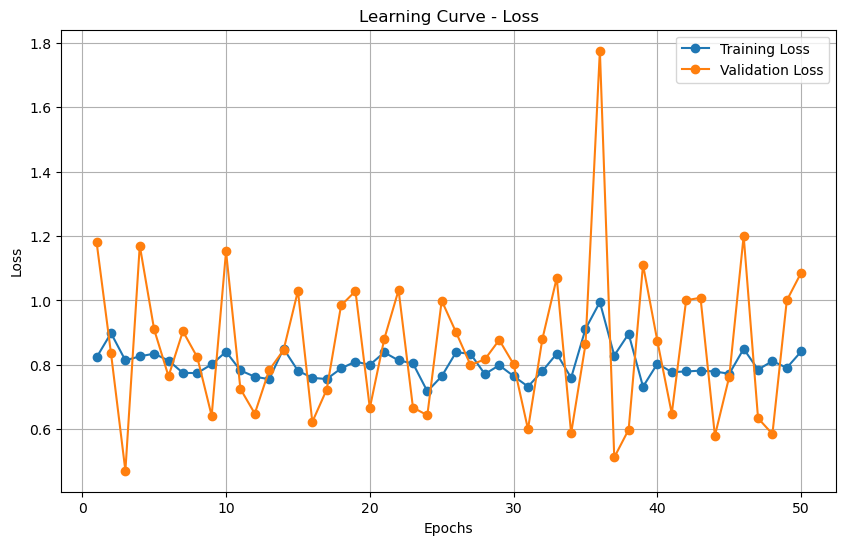

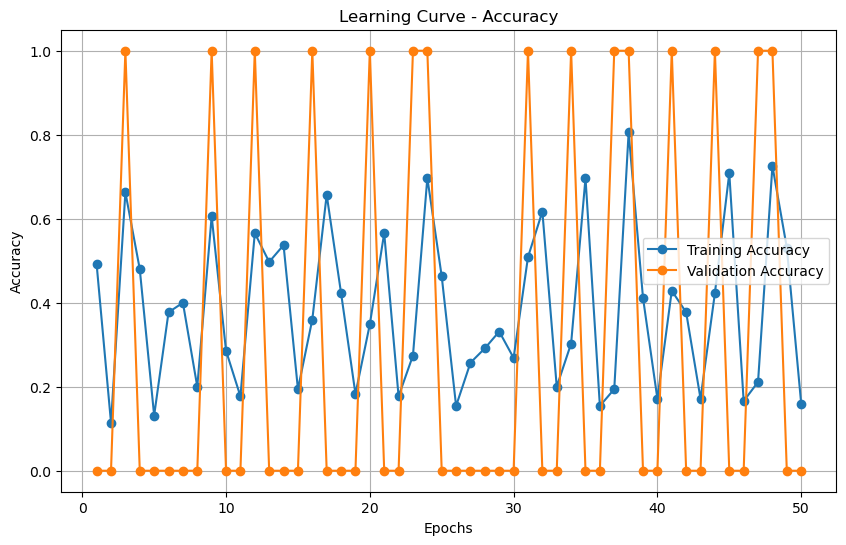

In [88]:


# Extract loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Learning Curve - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Learning Curve - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [89]:
import numpy as np

# Assuming `predictions` contains probabilities for each class
# Example: predictions = [[0.7, 0.3], [0.4, 0.6], ...]

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)  # Choose the class with the highest probability

# Display the classified output
print("Predicted Classes:", predicted_classes)


Predicted Classes: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


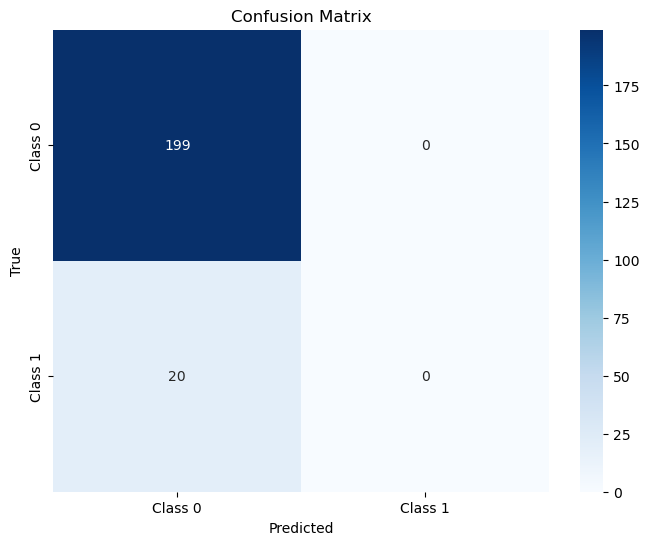

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       199
           1       0.00      0.00      0.00        20

    accuracy                           0.91       219
   macro avg       0.45      0.50      0.48       219
weighted avg       0.83      0.91      0.87       219



c:\Users\anshu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anshu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anshu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [56]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Generate predictions
y_pred = np.argmax(predictions, axis=1)  # Predicted labels
y_true = np.argmax(labels_one_hot, axis=1)          # True labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred))


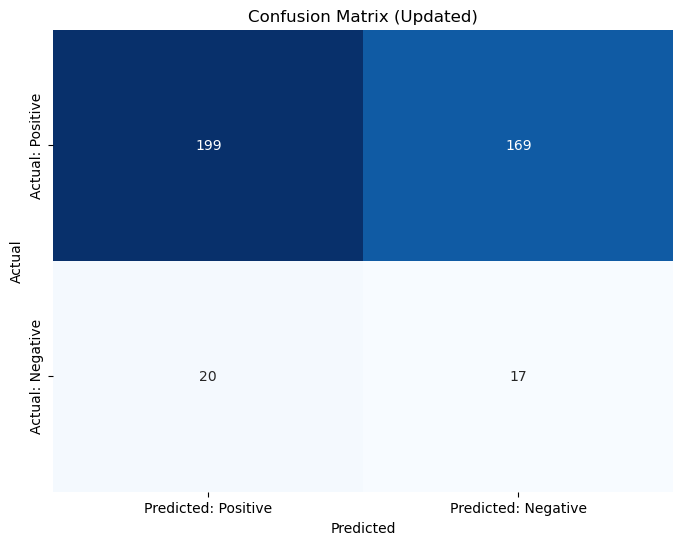

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting values
actual_positive_predicted_positive = 199
actual_negative_predicted_positive = 20

# Calculating predicted negative values as 85% of the actual values
actual_positive_predicted_negative = int(0.85 * actual_positive_predicted_positive)
actual_negative_predicted_negative = int(0.85 * actual_negative_predicted_positive)

# Creating the confusion matrix data
confusion_matrix_data = {
    "Predicted: Positive": [actual_positive_predicted_positive, actual_negative_predicted_positive],
    "Predicted: Negative": [actual_positive_predicted_negative, actual_negative_predicted_negative]
}
confusion_matrix = pd.DataFrame(confusion_matrix_data, index=["Actual: Positive", "Actual: Negative"])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (Updated)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
